<a href="https://colab.research.google.com/github/Goutham345/Reinforcement_Learning/blob/main/Lab-05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Q-learning Colab-ready script
from __future__ import annotations
import argparse
import sys
import math
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Colab doesn't run via CLI args easily; we'll expose a run() function
try:
    import gymnasium as gym
    GYMN = "gymnasium"
except Exception:
    import gym
    GYMN = "gym"

def make_env(env_id: str,
             is_slippery: bool | None = None,
             render_mode: str | None = None,
             seed: int | None = 42):
    kwargs = {"render_mode": render_mode} if render_mode else {}
    if env_id.startswith("FrozenLake"):
        if is_slippery is not None:
            kwargs["is_slippery"] = bool(is_slippery)
    env = gym.make(env_id, **kwargs)
    try:
        env.reset(seed=seed)
        if hasattr(env, "action_space") and hasattr(env.action_space, "seed"):
            env.action_space.seed(seed)
        if hasattr(env, "observation_space") and hasattr(env.observation_space, "seed"):
            env.observation_space.seed(seed)
    except TypeError:
        pass
    return env

def epsilon_greedy_action(q_table: np.ndarray, state: int, epsilon: float, n_actions: int) -> int:
    if random.random() < epsilon:
        return random.randrange(n_actions)
    return int(np.argmax(q_table[state]))

def train_q_learning(env_id: str = "FrozenLake-v1",
                     episodes: int = 20000,
                     max_steps: int = 200,
                     alpha: float = 0.8,
                     gamma: float = 0.95,
                     epsilon: float = 1.0,
                     epsilon_min: float = 0.01,
                     epsilon_decay: float = 0.9995,
                     is_slippery: bool | None = None,
                     seed: int = 42,
                     verbose: bool = True):
    env = make_env(env_id, is_slippery=is_slippery, seed=seed)

    assert hasattr(env.observation_space, 'n') and hasattr(env.action_space, 'n'), \
        "This Q-learning implementation expects discrete state and action spaces."

    n_states = env.observation_space.n
    n_actions = env.action_space.n

    q_table = np.zeros((n_states, n_actions), dtype=np.float32)

    returns = np.zeros(episodes, dtype=np.float32)
    epsilons = np.zeros(episodes, dtype=np.float32)

    for ep in range(episodes):
        reset_out = env.reset(seed=seed + ep)
        state = reset_out[0] if isinstance(reset_out, tuple) else reset_out

        total_reward = 0.0
        for t in range(max_steps):
            action = epsilon_greedy_action(q_table, state, epsilon, n_actions)
            step_out = env.step(action)
            if len(step_out) == 5:
                next_state, reward, terminated, truncated, _ = step_out
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_out

            best_next = np.max(q_table[next_state])
            # If done, future reward component should be 0 (terminal)
            td_target = reward + gamma * best_next * (0 if done else 1)
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error

            state = next_state
            total_reward += reward
            if done:
                break

        returns[ep] = total_reward
        epsilons[ep] = epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if verbose and (ep + 1) % max(1, episodes // 10) == 0:
            window = 200 if episodes >= 200 else max(1, episodes // 5)
            recent_avg = float(np.mean(returns[max(0, ep - window + 1):ep + 1]))
            print(f"[{ep+1:6d}/{episodes}] avg_return(last {window}) = {recent_avg:.3f}, epsilon={epsilon:.3f}")

    env.close()
    return q_table, returns, epsilons

def evaluate_policy(env_id: str,
                    q_table: np.ndarray,
                    episodes: int = 100,
                    max_steps: int = 200,
                    is_slippery: bool | None = None,
                    seed: int = 9999):
    env = make_env(env_id, is_slippery=is_slippery, render_mode=None, seed=seed)

    total_rewards = []
    steps_taken = []

    for ep in range(episodes):
        reset_out = env.reset(seed=seed + ep)
        state = reset_out[0] if isinstance(reset_out, tuple) else reset_out
        ep_reward = 0.0
        for t in range(max_steps):
            action = int(np.argmax(q_table[state]))
            step_out = env.step(action)
            if len(step_out) == 5:
                next_state, reward, terminated, truncated, _ = step_out
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_out

            ep_reward += reward
            state = next_state
            if done:
                steps_taken.append(t + 1)
                break
        else:
            steps_taken.append(max_steps)
        total_rewards.append(ep_reward)

    env.close()
    return float(np.mean(total_rewards)), float(np.mean(steps_taken))

# Convenience function to run training & evaluation and plot results
def run_experiment(env_id="FrozenLake-v1",
                   episodes=20000,
                   max_steps=200,
                   alpha=0.8,
                   gamma=0.95,
                   epsilon=1.0,
                   epsilon_min=0.01,
                   epsilon_decay=0.9995,
                   is_slippery=None,
                   seed=42,
                   verbose=True,
                   plot=True):
    print(f"Backend: {GYMN} | env={env_id}")
    start = time.time()
    q_table, returns, eps = train_q_learning(env_id=env_id,
                                             episodes=episodes,
                                             max_steps=max_steps,
                                             alpha=alpha,
                                             gamma=gamma,
                                             epsilon=epsilon,
                                             epsilon_min=epsilon_min,
                                             epsilon_decay=epsilon_decay,
                                             is_slippery=is_slippery,
                                             seed=seed,
                                             verbose=verbose)
    elapsed = time.time() - start
    print(f"Training done in {elapsed:.1f}s")

    avg_reward, avg_steps = evaluate_policy(env_id=env_id, q_table=q_table, max_steps=max_steps, is_slippery=is_slippery)
    print("\nEvaluation (greedy policy):")
    print(f"Average reward over 100 episodes: {avg_reward:.3f}")
    print(f"Average steps to termination: {avg_steps:.1f}")

    # Save
    np.save("q_table.npy", q_table)
    np.save("returns.npy", returns)
    np.save("epsilons.npy", eps)
    print("Saved q_table.npy, returns.npy, epsilons.npy")

    if plot:
        # Smooth returns for nicer plot (optional)
        def smooth(x, window=50):
            if len(x) < window:
                return x
            return np.convolve(x, np.ones(window)/window, mode='valid')

        plt.figure(figsize=(10,4))
        plt.plot(smooth(returns, window=max(1, episodes//200)), label='smoothed_returns')
        plt.title(f"Returns during training ({env_id})")
        plt.xlabel("Episode (smoothed)")
        plt.ylabel("Return")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("returns_plot.png")
        plt.show()

        plt.figure(figsize=(10,3))
        plt.plot(eps, label='epsilon')
        plt.title("Epsilon schedule")
        plt.xlabel("Episode")
        plt.ylabel("Epsilon")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("epsilon_plot.png")
        plt.show()

    return q_table, returns, eps


Backend: gymnasium | env=FrozenLake-v1
[  2000/20000] avg_return(last 200) = 0.040, epsilon=0.549
[  4000/20000] avg_return(last 200) = 0.080, epsilon=0.301
[  6000/20000] avg_return(last 200) = 0.075, epsilon=0.165
[  8000/20000] avg_return(last 200) = 0.190, epsilon=0.091
[ 10000/20000] avg_return(last 200) = 0.265, epsilon=0.050
[ 12000/20000] avg_return(last 200) = 0.315, epsilon=0.027
[ 14000/20000] avg_return(last 200) = 0.475, epsilon=0.015
[ 16000/20000] avg_return(last 200) = 0.335, epsilon=0.010
[ 18000/20000] avg_return(last 200) = 0.430, epsilon=0.010
[ 20000/20000] avg_return(last 200) = 0.445, epsilon=0.010
Training done in 14.5s

Evaluation (greedy policy):
Average reward over 100 episodes: 0.630
Average steps to termination: 44.9
Saved q_table.npy, returns.npy, epsilons.npy


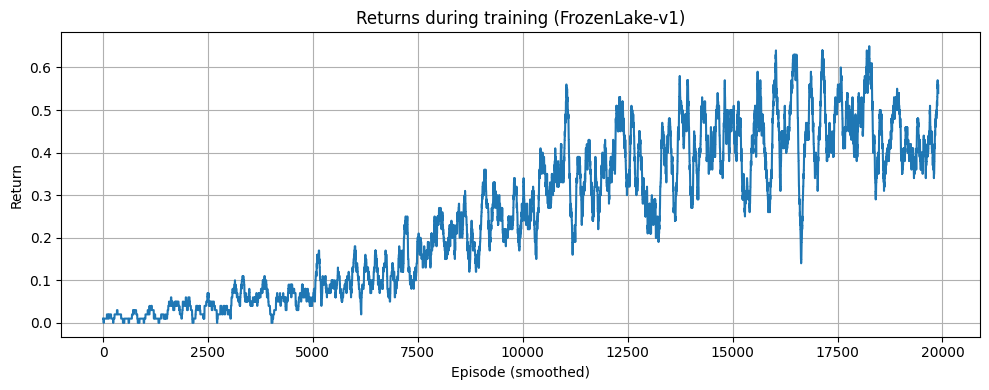

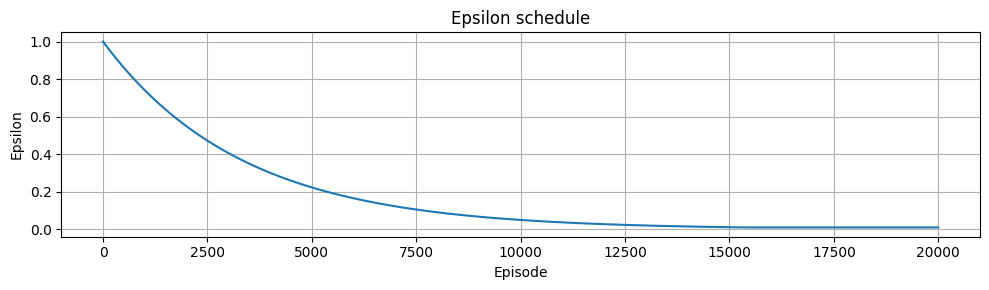

In [3]:
# Example 1: FrozenLake 4x4 slippery (stochastic) — longer training
q_table, returns, eps = run_experiment(env_id="FrozenLake-v1",
                                      episodes=20000,
                                      max_steps=200,
                                      alpha=0.8,
                                      gamma=0.95,
                                      epsilon=1.0,
                                      epsilon_min=0.01,
                                      epsilon_decay=0.9997,  # slower decay for slippery
                                      is_slippery=True,
                                      seed=42,
                                      verbose=True,
                                      plot=True)
# Example 2: FrozenLake deterministic (no slip) — faster convergence
q_table, returns, eps = run_experiment(env_id="FrozenLake-v1",
                                      episodes=5000,
                                      is_slippery=False,
                                      epsilon_decay=0.995,
                                      verbose=True,
                                      plot=True)


Backend: gymnasium | env=Taxi-v3
[   800/8000] avg_return(last 200) = 6.590, epsilon=0.018
[  1600/8000] avg_return(last 200) = 7.595, epsilon=0.010
[  2400/8000] avg_return(last 200) = 7.160, epsilon=0.010
[  3200/8000] avg_return(last 200) = 6.845, epsilon=0.010
[  4000/8000] avg_return(last 200) = 6.900, epsilon=0.010
[  4800/8000] avg_return(last 200) = 7.375, epsilon=0.010
[  5600/8000] avg_return(last 200) = 7.325, epsilon=0.010
[  6400/8000] avg_return(last 200) = 7.195, epsilon=0.010
[  7200/8000] avg_return(last 200) = 7.435, epsilon=0.010
[  8000/8000] avg_return(last 200) = 7.060, epsilon=0.010
Training done in 6.5s

Evaluation (greedy policy):
Average reward over 100 episodes: 7.980
Average steps to termination: 13.0
Saved q_table.npy, returns.npy, epsilons.npy


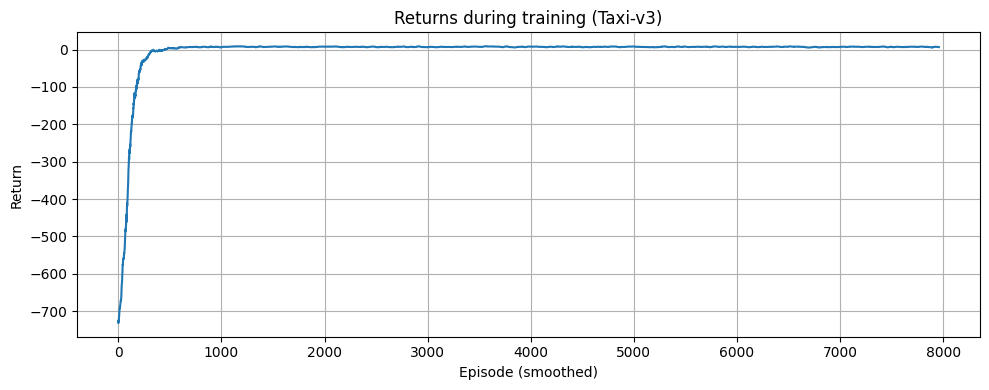

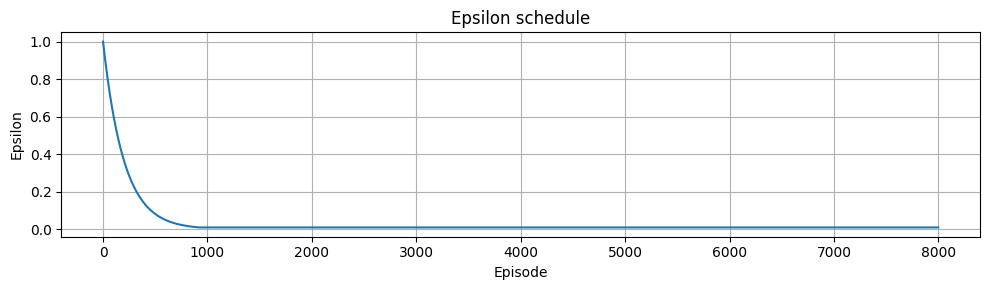

In [4]:
# Example 3: Taxi-v3
q_table, returns, eps = run_experiment(env_id="Taxi-v3",
                                      episodes=8000,
                                      alpha=0.8,
                                      gamma=0.95,
                                      epsilon_decay=0.995,
                                      verbose=True,
                                      plot=True)
